# Analise de Sentimentos - Ingles x Portugues 
### Utilizando a API de Natural Language do Google
---

* **[Link para o artigo no Medium:](https://medium.com/@andrebastos85/an%C3%A1lise-de-sentimentos-ingl%C3%AAs-x-portugu%C3%AAs-1469fdd2bae9?sk=3af2bdc28b6fbda1d3f160e07d0b72e3)**

* **[Link para visualização do notebook pelo NBViewer: (necessário para visualização dos gráficos)](https://nbviewer.jupyter.org/github/andrepombo/Portfolio/blob/master/analise_sentimentos.ipynb)**

### Introduçāo

A análise de sentimentos através do **Processamento de Linguagem Natural (Natural Language Processing — NLP)**, se tornou um tema muito abordado no mundo acadêmico e corporativo, muito devido ao crescente número de aplicações práticas, tais como:

- Identificar se uma avaliação feita em um livro na Amazon foi positiva ou negativa;
- Identificar sintomas de depressão em pessoas a partir de suas postagens em redes sociais como Facebook ou Twitter;
- Encontrar potenciais eleitores favoráveis a um determinado candidato.

Muitos métodos e ferramentas têm sido desenvolvidos para a detecção de sentimentos em diversos ambientes e casos. Contudo, grande parte dos recursos para tais análises estão disponibilizados apenas na língua inglesa, considerando que esta é a língua predominante no mundo. 
Entre as diversas ferramentas para tais análises a **API de Natural Language do Google** tem se destacado como uma ótima opção por possuir suporte a vários [idiomas](https://cloud-dot-devsite-v2-prod.appspot.com/natural-language/docs/languages), entre eles o portugues.

<center><img src="img/googleapi.png" width="400" height="200"></center>

### Sobre este estudo

Recentemente utilizei pela primeira vez esta API para um trabalho da pos-graduacao. Meu colega de equipe sugeriu utilizar como base para o trabalho, o renomado Dataset do **IMDB** de reviews de filmes, este dataset originalmente se encontra apenas em inglês mas um usuário do **Kaggle** (Plataforma para projetos e competições de Data Science) traduziu o dataset para português e o dispôs na sua página pessoal da plataforma [(Luís Fred)](https://www.kaggle.com/luisfredgs/imdb-ptbr). 

Segundo o próprio Luís a tradução foi feita automaticamente, usando uma ferramenta de tradução apropriada que apesar de não citada fez um trabalho muito bom. A título de comparação utilizei outra API do Google **(Cloud Translation API)** para traduzir algumas da reviews, e pude verificar que os resultados também possuíam uma ótima qualidade e grande similaridade apesar de não serem totalmente iguais.

O trabalho desenvolvido para a pós possuía outro foco e utilizou-se apenas dos dados traduzidos em português, mas me fez pensar se haveria diferença na classificação do sentimento, utilizando exatamente o mesmo texto apenas com idiomas diferentes. 

**Neste notebook, iremos verificar e analisar as diferenças e similaridades das duas versões de textos através da API de Natural Language do Google.**

## Importando Blibliotecas e *Dataset*

In [435]:
# importar os pacotes necessários
import pandas as pd
import numpy as np

# Bibliotecas para analise de sentimento
from google.cloud import language_v1
import six

# Bibliotecas para processamento em paralelo
from joblib import Parallel, delayed
import multiprocessing

# Bibliotecas para visualizacao de graficos
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot  as plt
%matplotlib inline

In [436]:
# importar o dataset em csv 
df = pd.read_csv('imdb-pt.csv', sep=',', error_bad_lines=False)
# ver as 5 primeiras entradas
df.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


## Amostra 

O uso da API Natural Language é pago e o preço é calculado de acordo com o número de “unidades” usadas mensalmente. 
Cada documento, no nosso caso review enviado para a API para análise conta como pelo menos uma unidade. Documentos com mais de 1.000 caracteres unicode (incluindo caractere de espaço em branco e todos os de marcação, como tags HTML ou XML) são considerados como várias unidades. Considera-se uma unidade a cada 1.000 caracteres.

Por exemplo, se você enviar três solicitações à API Natural Language com 800, 1.500 e 600 caracteres respectivamente, você será cobrado por quatro unidades: uma para a primeira solicitação (800), duas para a segunda solicitação (1.500) e uma para a terceira solicitação (600).


### <center>Preço Mensal (US\$)</center>
|Recurso (Unidades) | 0 a 5.000     | 5.001 a 1.000.000     | 1.000.001 a 5.000.000    | 5.000.0001 a 20.000.000     |
|:------|:------:|:------:|:------:|:-----:|
|Analise de Sentimentos  | Gratis| US$ 1,00| US\$ 0,50 | US\$ 0,25|

In [437]:
# identificar dimensões do DataFrame
df.shape

(49459, 4)

Aplicando o método `len` as colunas  text_en e text_pt conseguimos avaliar quantos caracteres cada entrada possui.

In [438]:
# Adicionar as colunas com o numero de caracteres para os dois idiomas.
df['length_en'] = df['text_en'].apply(len)
df['length_pt'] = df['text_pt'].apply(len)

Por meio do método describe, é possível ver um resumo estatístico das variáveis numéricas e verificar a média de caracteres por coluna.

In [439]:
df.describe()

,id,length_en,length_pt
count,49459.000000,49459.000000,49459.000000
mean,24730.960917,1228.475283,1281.848925
std,14277.792868,852.181841,887.017874
min,1.000000,32.000000,30.000000
25%,12366.500000,683.000000,714.000000
50%,24731.000000,939.000000,982.000000
75%,37095.500000,1517.000000,1581.000000
max,49460.000000,5000.000000,5335.000000


Nosso dataset se aproxima de 50.000 mil entradas, contendo em média 1.250 caracteres cada. 
Cada entrada contaria como duas unidades e teríamos então um total de 100.000 mil unidades, como aplicaremos a função de análise em cima de dois idiomas esse valor duplicaria para 200.000 unidades!! e isso tornaria nossa análise muito custosa e demorada.

Para facilitar nossa análise e manter a confiabilidade do experimento, foi gerada uma amostra a partir do conjunto de dados inicial.
Para construir a amostra, 381 reviews foram selecionados aleatoriamente do conjunto de dados do IMDB que possui 49.459 entradas. O tamanho da amostra foi determinado após especificar um nível de confiança de 95% e uma margem de erro de 5%.


In [440]:
# Reduzindo o dataframe a 381 entradas aleatorias
amostra = df.sample(381)

## Processamento em Paralelo

Nosso conteúdo para análise foi reduzido consideravelmente mas imagine que quiséssemos continuar com o conteúdo original, isso geraria uma demanda imensa de requisições a API do Google, cada uma com seu próprio tempo de processamento e resposta. Não que os servidores poderosíssimos de uma empresa como a GOOGLE sejam lentos (Bem longe disso) mas existindo a possibilidade de acelerar esse processo ainda mais porque não nos aproveitarmos dele. 

Se fossemos fazer uma iteração normal entre todos os elementos a serem analisados, cada review dentro do nosso loop seria sequencialmente (um a um) enviado a API , analisado e retornado uma resposta, levando um tempo considerável e é aí que entra o processamento paralelo.

Basicamente processamento em paralelo é fazer duas ou mais coisas ao mesmo tempo, isso é possível rodando seu código em diferentes núcleos do computador simultaneamente. A utilização deste método de processamento possibilita que uma tarefa não tenha que correr de forma sequencial, nos dando a opção de configurar a função analyze_sentiment(content) para que faça várias requisições concomitantes a API, utilizando núcleos diferentes consequentemente tendo um ganho em performance. 

O parâmetro n_jobs seleciona o número de processos simultâneos que deverão ser iniciados e multiprocessing.cpu_count() conta automaticamente o número de núcleos do computador para que este seja aproveitado ao máximo.

In [442]:
# Contagem do numeros de cores
num_cores = multiprocessing.cpu_count()

In [441]:
def analyze_sentiment(content):
    client = language_v1.LanguageServiceClient()

    # content = 'Your text to analyze, e.g. Hello, world!'

    if isinstance(content, six.binary_type):
        content = content.decode('utf-8')

    type_ = language_v1.Document.Type.PLAIN_TEXT
    #document = {'content': content}
    document = language_v1.Document(content=content, type_=language_v1.Document.Type.PLAIN_TEXT)

    response = client.analyze_sentiment(request={"document": document})
    sentiment = response.document_sentiment
    score = sentiment.score
    magnitude = sentiment.magnitude
    
    return score,magnitude

In [468]:
%%time
result_text_pt = Parallel(n_jobs=num_cores)(delayed(analyze_sentiment)(frase) for frase in amostra.text_pt)

CPU times: user 2.03 s, sys: 125 ms, total: 2.16 s
Wall time: 1min 49s


In [469]:
%%time
result_text_en = Parallel(n_jobs=num_cores)(delayed(analyze_sentiment)(frase) for frase in amostra.text_en)

CPU times: user 1.99 s, sys: 132 ms, total: 2.12 s
Wall time: 2min 4s


In [488]:
# Criando as colunas de score e magnitude para ambos idiomas 
amostra['score_en'], amostra['magnitude_en'] = zip(*result_text_en) 
amostra['score_pt'] ,amostra['magnitude_pt'] = zip(*result_text_pt)  

### Resultados

In [25]:
amostra.head()

,id,text_en,text_pt,sentiment,length_en,length_pt,score_en,magnitude_en,score_pt,magnitude_pt
31240,31242,At first glance this gives the impression that...,"À primeira vista, isso dá a impressão de que s...",neg,1488,1532,-0.2,4.4,0.0,3.2
19670,19672,I may differ from many people on this board bu...,Eu posso diferir de muitas pessoas neste fórum...,pos,1948,2058,-0.2,9.5,0.1,5.6
42494,42496,I love it when they actually do a sports story...,Eu adoro quando eles realmente fazem uma histó...,pos,1120,1244,0.1,4.9,0.2,5.2
34972,34974,The viewer leaves wondering why he bothered to...,O espectador deixa se perguntando por que se i...,neg,269,300,-0.5,1.7,-0.2,0.8
5366,5368,"This is the story of a maniac cop who, for som...","Esta é a história de um policial maníaco que, ...",neg,1606,1708,-0.4,4.9,0.0,2.9


## Avaliando os Resultados

A análise de sentimento da API de Natural Language do Google tenta determinar a atitude geral do documento e é representada por valores numéricos score e magnitude.

Para classificar corretamente o sentimento de textos, é necessário interpretar esses dois valores. Enquanto o score representa o sentimento geral do conteúdo (positivo ou negativo), a magnitude indica o conteúdo emocional presente nele, e esse valor é segundo a GOOGLE geralmente proporcional ao tamanho do documento. Resumidamente:
- Score: indica o range do sentimento, onde -1.0 representa o limite de um sentimento negativo e 1.0 o limite de um sentimento positivo.
- Magnitude: Indica a força geral da emoção classificada no score. Diferente do score, a magnitude não é normalizada e varia entre os intervalos de 0.0 e +inf.


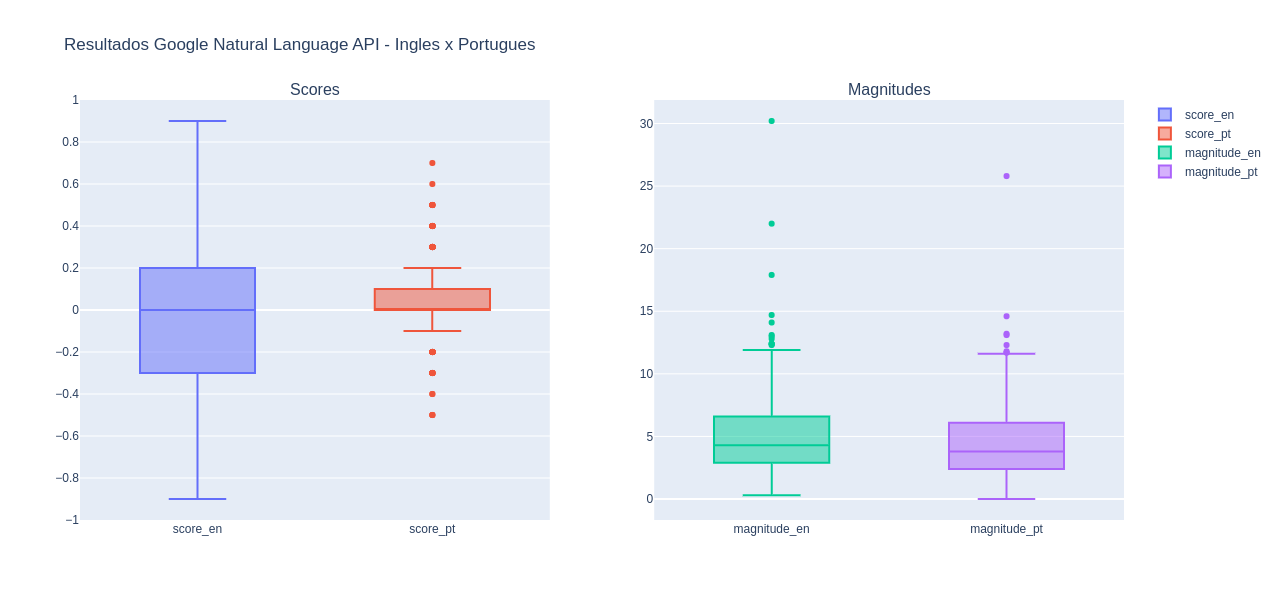

In [599]:
# Plotando Boxplot
y1 = amostra.score_en
y2 = amostra.score_pt
y3 = amostra.magnitude_en
y4 = amostra.magnitude_pt

fig1 = make_subplots(rows=1, cols=2, subplot_titles=("Scores", "Magnitudes"))

fig1.add_trace(go.Box(y=y1, name='score_en'), row=1, col=1)
fig1.add_trace(go.Box(y=y2, name='score_pt'), row=1, col=1)
fig1.add_trace(go.Box(y=y3, name='magnitude_en'), row=1, col=2)
fig1.add_trace(go.Box(y=y4, name='magnitude_pt'), row=1, col=2)

fig1.update_layout(height=600, title_text="Resultados Google Natural Language API - Ingles x Portugues", title_x =0.05)
fig1.show()

Do Box Plot podemos ver uma considerável diferença em amplitudes nos scores. Enquanto que na Língua Inglesa tivemos uma uma grande variação de valores, os sscores para a Língua Portuguesa se concentraram ao redor de 0, com a exceção de alguns Outliers.

A fim de termos uma visualização mais intuitiva dos resultados, iremos classificá-los em **Positivos, Neutros ou Negativos**, segundo seu score. [Demonstração da API Natural Language](https://cloud.google.com/natural-language)

In [489]:
# Classificando scores em Positivo, Neutro ou Negativo
conditions1 = [    
    (amostra['score_en'] > 0.25),
    (amostra['score_en'] <= 0.25) & (amostra['score_en'] >= -0.25 ),
    (amostra['score_en'] < -0.25 ),
    ]
conditions2 = [    
    (amostra['score_pt'] > 0.25 ),
    (amostra['score_pt'] <= 0.25) & (amostra['score_pt'] >= -0.25 ),
    (amostra['score_pt'] < -0.25 ),
    ]
choices = ['pos','neutro','neg']

amostra['sentiment_en'] = np.select(conditions1, choices, default='null')
amostra['sentiment_pt'] = np.select(conditions2, choices, default='null')

###  Score Range ( 1 a -1 )

- Positivo > 0.25   **(37.5%)**
- Neutro <= 0.25 e >=-0.25   **(25%)**
- Negativo < -0.25  **(37.5%)**

In [545]:
a1 = amostra.groupby('sentiment_en').count()
a2 = amostra.groupby('sentiment_pt').count()
neutro1 = a1.loc["neutro"].id 
neg1 = a1.loc["neg"].id 
pos1 = a1.loc["pos"].id 
neutro2 = a2.loc["neutro"].id
neg2 = a2.loc["neg"].id 
pos2 = a2.loc["pos"].id

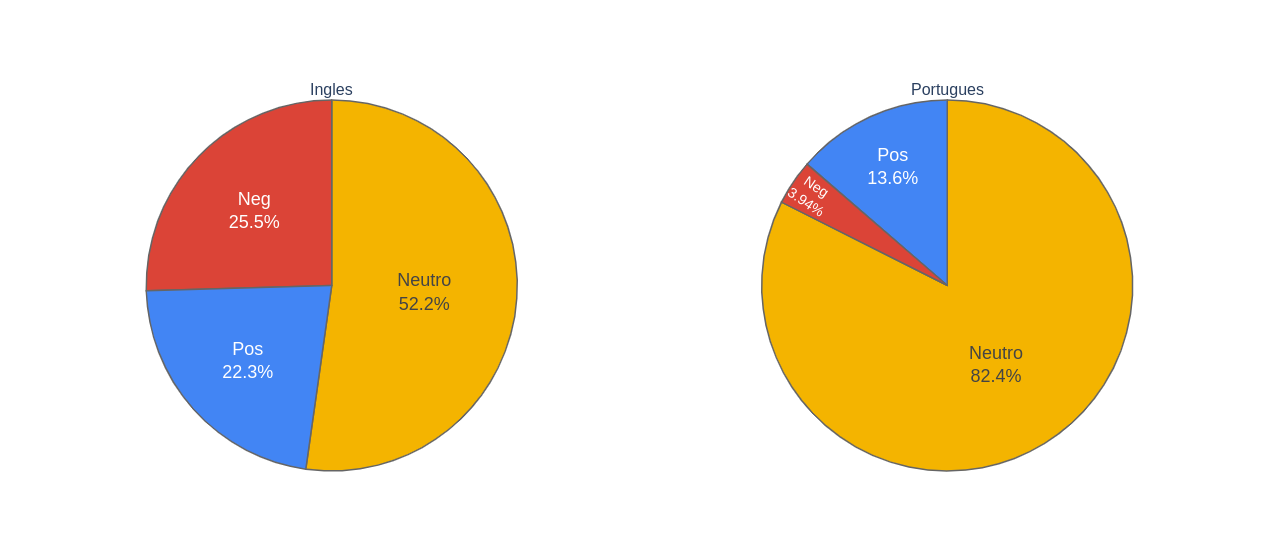

In [600]:
# Define Labels
labels = ['Neutro','Pos', 'Neg']

# Define color sets of paintings
colors = ['rgb(244, 180, 0)', 'rgb(66, 133, 244)',  'rgb(219, 68, 55)']


# Create subplots, using 'domain' type for pie charts
specs = [[{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['Ingles', 'Portugues'])

# Define pie charts
fig.add_trace(go.Pie(labels=labels, values=[neutro1,pos1,neg1], name='Ingles',
               marker_colors=colors,hoverinfo='label+percent', 
               textfont=dict(size=18),
               marker=dict(colors=colors, 
               line=dict(color='rgb(101,101,101)', width=1.5))), 1, 1)

fig.add_trace(go.Pie(labels=labels, values=[neutro2,pos2,neg2], name='Portugues',
               marker_colors=colors,hoverinfo='label+percent', 
               textfont=dict(size=18),
               marker=dict(colors=colors, 
               line=dict(color='rgb(101,101,101)', width=1.5))), 1, 2)

# Tune layout and hover info
fig.update_layout(height=550,  title_x=0.2)
fig.update_traces(textposition='inside', textinfo='percent+label',hoverinfo='label+percent+name')
fig.update(#layout_title_text='% Porcentagem dos Sentimentos por Lingua',
           layout_showlegend=False)

fig = go.Figure(fig)

fig.show()

Teoricamente os resultados da análise de sentimentos deveriam ser os mesmos ou muito parecidos pois as informações, opiniões e emoções contidas nos textos analisados apesar de serem em idiomas diferentes são as mesmas. 

Podemos constatar no entanto que na Língua Inglesa apesar de mais de 50% das análises serem neutras, essa classificação ainda assim se manteve de uma certa maneira balanceada em comparação a Língua Portuguesa que praticamente não obteve respostas negativas e mais de 80% de neutras.


### Correlacões

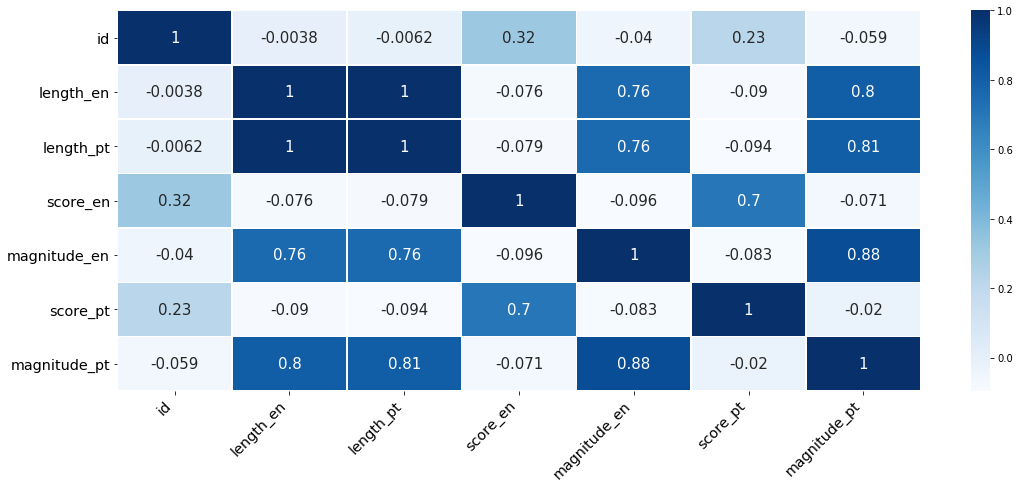

In [596]:
# Gerar dataframe de correlações
z = amostra.corr()

# Plotar heatmap
plt.figure(figsize=(18,7))
g = sns.heatmap(z, cmap='Blues', linewidths=0.5, annot=True,annot_kws={"size": 15})
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize='x-large')
g.set_xticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize='x-large')

In [598]:
figure = g.get_figure()    
figure.savefig('heatmap.png', dpi=200)

Através do Heatmap podemos constatar uma alta correlação positiva entre magnitudes e tamanho do texto, confirmando a afirmação da GOOGLE de que essas variáveis são proporcionais e de que quanto maior o texto maior a magnitude.

## Reflexões

Seria o idioma Portugues uma Lingua menos negativa e mais neutra ou que algoritmo do GOOGLE para esse idioma ainda precise passar por refinamentos?